In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
inspector=inspect(engine)  # another way to get data from a db
inspector.get_table_names()

['measurement', 'station']

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine,reflect=True)

In [7]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Station = Base.classes.station
Msrmt = Base.classes.measurement

In [9]:
# Create session (link) from Python to the DB
session = Session(engine)

In [10]:
#Check out row of Station data
first_row = session.query(Station).first()
first_row.__dict__ 

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x28a77c53198>,
 'longitude': -157.8168,
 'name': 'WAIKIKI 717.2, HI US',
 'id': 1,
 'elevation': 3.0,
 'latitude': 21.2716,
 'station': 'USC00519397'}

In [11]:
#Check out row of Measurement data
#tobs=temperature observation data
first_row = session.query(Msrmt).first()
first_row.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x28a77c53d68>,
 'tobs': 65.0,
 'date': '2010-01-01',
 'id': 1,
 'prcp': 0.08,
 'station': 'USC00519397'}

# Exploratory Precipitation Analysis

In [31]:
# Find the most recent date in the data set.
recent_date =session.query(Msrmt.date).order_by(Msrmt.date.desc()).limit(1)  #could do first() here
print(recent_date[0][0])
date_str = recent_date[0][0]
#print(type(recent_date))  
dated = dt.datetime.strptime(date_str,'%Y-%m-%d')

2017-08-23


In [32]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 

# Calculate the date one year from the last date in data set.
yearago=dated.date()-dt.timedelta(days=365)#dt.date(2017,8,23)-dt.timedelta(days=365)
print(f"Query date range: {yearago} to {recent_date[0][0]}")
# Perform a query to retrieve the data and precipitation scores.  Order the data by date and populate dataframe
last12mosrain_df =pd.DataFrame(session.query(Msrmt.date,Msrmt.prcp).filter(Msrmt.date >= yearago).order_by(Msrmt.date).all())

last12mosrain_df['date'] = pd.to_datetime(last12mosrain_df['date'])

Query date range: 2016-08-23 to 2017-08-23


In [14]:
#set index to be the date
last12mosrain_df.set_index('date', inplace=True)

In [15]:
from dateutil.relativedelta import *
#create list for xaxis graph ticks
yearticks=[]
for i in range(13):
    #print(yearago+relativedelta(months=+i)) #testing output
    yearticks.append(yearago+relativedelta(months=+i))

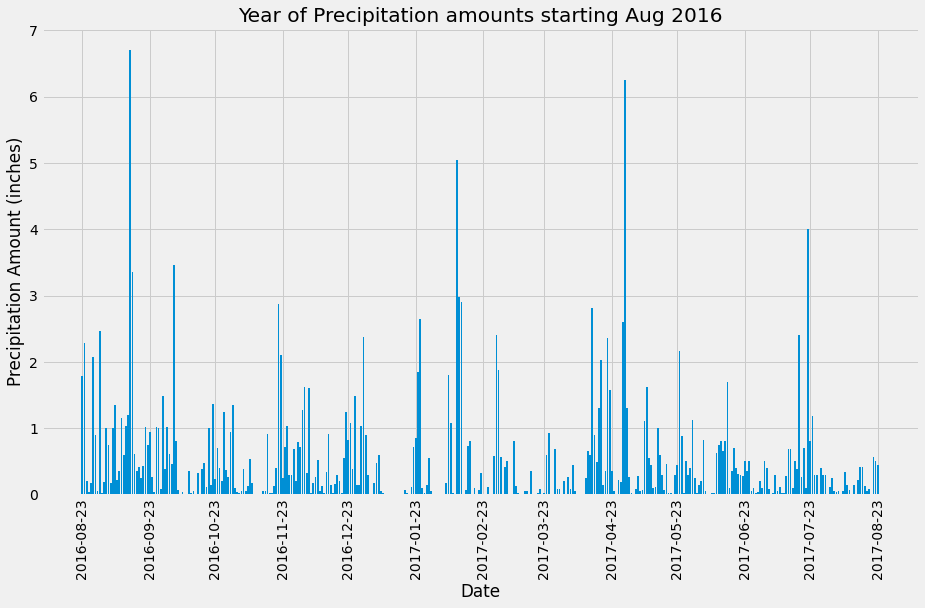

In [16]:
# Plot bar graph of the year of precipt

plt.figure(figsize=(14,8))
plt.bar(x=last12mosrain_df.index, height=last12mosrain_df.prcp)

plt.title('Year of Precipitation amounts starting Aug 2016')
plt.xlabel('Date')
plt.ylabel('Precipitation Amount (inches)')
plt.xticks(yearticks, rotation="vertical")
plt.show()

In [17]:
# summary statistics for the precipitation data
last12mosrain_df.describe()

,prcp
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [18]:
# Design a query to calculate the total number stations in the dataset
stationCount=uniqueLocs=session.query(func.count(Station.station)).all()
print(f"Count of stations: {stationCount[0][0]}")

stationCount2ndmethod=session.execute("select count(*) from station") #another way to get this number
stations=session.execute("select * from station")
for row in stations:
    print(row)

Count of stations: 9
(1, 'USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0)
(2, 'USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6)
(3, 'USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0)
(4, 'USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9)
(5, 'USC00518838', 'UPPER WAHIAWA 874.3, HI US', 21.4992, -158.0111, 306.6)
(6, 'USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 21.33556, -157.71139, 19.5)
(7, 'USC00519281', 'WAIHEE 837.5, HI US', 21.45167, -157.84888999999998, 32.9)
(8, 'USC00511918', 'HONOLULU OBSERVATORY 702.2, HI US', 21.3152, -157.9992, 0.9)
(9, 'USC00516128', 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4)


In [19]:
# find the most active station
uniqueLocs=session.query(Msrmt.station, func.count(Msrmt.station)).group_by(Msrmt.station).order_by(func.count(Msrmt.station).desc()).all()
# List the stations and the counts in descending order.
for row in uniqueLocs:
    print(row)

('USC00519281', 2772)
('USC00519397', 2724)
('USC00513117', 2709)
('USC00519523', 2669)
('USC00516128', 2612)
('USC00514830', 2202)
('USC00511918', 1979)
('USC00517948', 1372)
('USC00518838', 511)


In [20]:
# query, calculate the lowest, highest, and average temperature for the most active station
mostActiveStation=uniqueLocs[0][0]  #results are ordered desc, so 1st one has highest count
mas_stats=session.query(func.min(Msrmt.tobs), func.max(Msrmt.tobs), func.avg(Msrmt.tobs)).filter(Msrmt.station==mostActiveStation).all()
for stats in mas_stats:
    print(f"Station {mostActiveStation} temperature stats- min:{stats[0]}, max:{stats[1]}, min:{round(stats[2],2)}")

Station USC00519281 temperature stats- min:54.0, max:85.0, min:71.66


In [21]:
# Query the last 12 months of temperature observation data for most active station and plot the results as a histogram
#mas station has different latest date
mas_recent_date =session.query(Msrmt.date).filter(Msrmt.station==mostActiveStation).order_by(Msrmt.date.desc()).limit(1)

mas_recent_date[0][0]
mas_yearago=dt.date(2017,8,18)-dt.timedelta(days=365)

print(f"Query date range: {mas_yearago} to {mas_recent_date[0][0]}")
# 
last12mostmp_df =pd.DataFrame(session.query(Msrmt.date,Msrmt.tobs).filter(Msrmt.date >= mas_yearago).filter(Msrmt.station==mostActiveStation).all())

Query date range: 2016-08-18 to 2017-08-18


Text(0, 0.5, 'Frequency')

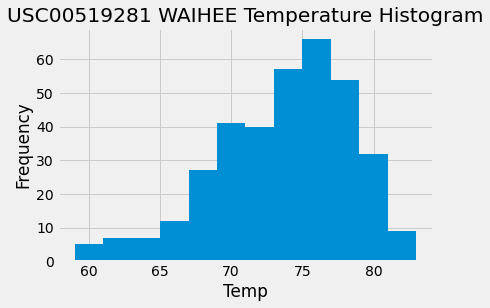

In [22]:
plot = last12mostmp_df.tobs.hist(bins=12)
plot.set_title("USC00519281 WAIHEE Temperature Histogram")
plot.set_xlabel("Temp")
plot.set_ylabel("Frequency")

# Close session

In [23]:
# Close Session
session.close()

In [24]:
#TODO delete me
#futzing box

results = session.query(Station.id,Station.station, Station.name, Station.elevation,Station.latitude,Station.longitude).all()
all_stations = list(np.ravel(results))
session.close()  
#    all_stations=[]
#    for row in results:#longitude,name,id,elevation,latitude,station_id in results:
#        all_stations.append(row)

In [30]:
query_date = dt.datetime.strptime('2010-08-23','%Y-%m-%d')
print(type(query_date))

#"""Return a JSON list of the minimum temperature, the average temperature, and the max temperature for a given start"""
stats_results=session.query(func.min(Msrmt.tobs), func.avg(Msrmt.tobs), func.max(Msrmt.tobs)).filter(Msrmt.date >= query_date).all()

for row in stats_results:
    print(row)

<class 'datetime.datetime'>
(53.0, 73.2019770838014, 87.0)
